[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/IPML/blob/master/tutorial_notebooks/9_classification_tasks.ipynb) 

# Classification 

In this notebook, we will revisit our lecture on classification models. To that end, we consider the logistic regression model and study how it allows us to approach a probability-to-default prediction task. As usual, we provide ready-to-use demo codes and small programming tasks. 

## Preliminaries
We continue using the HMEQ classification data sets. Beyond loading standard libraries, the following code block reads the data from our [GitHub repository](https://github.com/Humboldt-WI/IPML/tree/main) and performs some preprocessing operations, which we introduced in earlier tutorials. Since future tutorials will need the same functionality, we encapsulate the code in a function called `get_credit_risk_data()`.


In [1]:
# Load standard libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# We put all codes to retrieve and prepare our credit risk data into a custom function
def get_credit_risk_data(outlier_factor=2):
    # Load credit risk data directly from GitHub
    data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq.csv'
    hmeq = pd.read_csv(data_url)

    # Code categories properly 
    hmeq['REASON'] = hmeq['REASON'].astype('category')
    hmeq['JOB'] = hmeq['JOB'].astype('category')
    hmeq = pd.get_dummies(hmeq, drop_first=True)  
    
    # Code the target variable properly
    hmeq['BAD'] = hmeq['BAD'].astype('bool')
    
    # Downcast numerical columns to save memory
    ix_numeric_columns = hmeq.select_dtypes(include=np.number).columns
    hmeq[ix_numeric_columns] = hmeq[ix_numeric_columns].astype('float32')

    # Handle missing values:
    # 1. The feature DEBTINC is important but suffers many missing values. Blindly replacing these missing values
    #    would introduce bias and harm any model trained on the data. To avoid this, we add a dummy variable
    #    to indicate whether the feature value was missing or not.
    hmeq['D2I_miss'] = hmeq['DEBTINC'].isna().astype('category')
    # 2. For the other numerical features, we use the median to impute missing values. For the categorical features
    imputer = SimpleImputer(strategy='median')  # Create an imputer object with the strategy 'median'
    hmeq[ix_numeric_columns] = imputer.fit_transform(hmeq[ix_numeric_columns])  
    # 3. For the categorical features, we use the mode to impute missing values
    ix_cat = hmeq.select_dtypes(include=['category']).columns  # Get an index of the categorical columns
    for c in ix_cat:  # Process each category
        hmeq.loc[hmeq[c].isna(), c ] = hmeq[c].mode()[0]  # the index [0] is necessary as the result of calling mode() is a Pandas Series
    
    # Truncate outliers among numerical features
    if outlier_factor > 0:
        for col in ix_numeric_columns:
            if col not in ['DELINQ', 'DEROG']:  # We do not truncate these features as their distribution if strongly skewed such outlier trunction would leave us with a constant feature
                q1 = hmeq[col].quantile(0.25)
                q3 = hmeq[col].quantile(0.75)
                iqr = q3 - q1
                lower_bound = q1 - outlier_factor * iqr
                upper_bound = q3 + outlier_factor * iqr
                hmeq[col] = hmeq[col].clip(lower=lower_bound, upper=upper_bound)

    # Scale numerical features
    scaler = StandardScaler()
    hmeq[ix_numeric_columns] = scaler.fit_transform(hmeq[ix_numeric_columns])

    # Separate the target variable and the feature matrix
    y = hmeq.pop('BAD')
    X = hmeq

    return X, y

# Call the function to retrieve the data
X, y = get_credit_risk_data()   

# Preview the data
X



,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,D2I_miss
0,-1.747149,-1.247362,-1.282522,0.245139,-0.280976,-0.375943,-1.064629,-0.081701,-1.259284,0.140621,True,False,True,False,False,False,True
1,-1.726783,-0.035071,-0.657733,-0.241442,-0.280976,1.477341,-0.717490,-0.791521,-0.741296,0.140621,True,False,True,False,False,False,True
2,-1.706418,-1.586418,-1.757361,-0.658511,-0.280976,-0.375943,-0.368245,-0.081701,-1.155687,0.140621,True,False,True,False,False,False,True
3,-1.706418,-0.173162,-0.214575,-0.241442,-0.280976,-0.375943,-0.064920,-0.081701,-0.119711,0.140621,False,False,False,False,False,False,True
4,-1.686053,0.726077,0.269613,-0.797535,-0.280976,-0.375943,-1.077688,-0.791521,-0.741296,0.140621,True,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,2.997931,-0.385896,-0.194379,1.009766,-0.280976,-0.375943,0.546053,-0.791521,-0.534101,0.347904,False,False,True,False,False,False,False
5956,2.997931,-0.459632,-0.135846,1.009766,-0.280976,-0.375943,0.380278,-0.791521,-0.637699,0.307479,False,False,True,False,False,False,False
5957,2.997931,-0.474198,-0.136122,0.870743,-0.280976,-0.375943,0.425620,-0.791521,-0.637699,0.258884,False,False,True,False,False,False,False
5958,2.997931,-0.575010,-0.158732,0.731720,-0.280976,-0.375943,0.446007,-0.791521,-0.534101,0.064156,False,False,True,False,False,False,False


# Binary classification for PD modeling
Having prepared our data, we can proceed with predictive modeling. The lecture introduced the general classification setup and the logistic regression model. Let's revisit these elements in detail. 

## Excercise 1: Plotting data for classification
You will remember the many plots we came across when discussing regression. We also saw some analog plots for classification problems in the lecture. One of them was a 2d scatter plot displaying the bi-variate relationship between selected features and the binary target variable. 

![Classification problem in 2D](https://raw.githubusercontent.com/stefanlessmann/ESMT_IML/main/resources/2d_classification_problem.png)

Your first task is to create a similar plot for the credit data. In principle, you can select any combination of features that you like.  

In [2]:
# Exercise 1


# Logistic regression
Time to estimate our first classification model. We will use logistic regression. Think of it as an extension of linear regression for cases in which we work with a binary target variable. Just as in linear regression, logistic regression involves model training on labelled data. The below code uses the `sklearn` library to train a logistic regression-based classification model. In case you receive a warning message when running the code (i.e., *Convergence warning*), please ignore this message for now. 


In [3]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=123)  # the random_state ensures that we get the same results when re-running this cell multiple times
model.fit(X, y)  # Train the model
print(model)

LogisticRegression(random_state=123)


Note that the `sklearn` implementation does not provide an informative summary, as did the library `statsmodels`, which we used to [illustrate regression analysis](https://github.com/Humboldt-WI/IPML/blob/master/tutorial_notebooks/5_SML_for_regression_solutions.ipynb). You can still access the estimated coefficients and the intercept using the attributes `coef_` and `intercept_` of the fitted model. However, $R^2$, p-values or confidence intervals are not available. In brief, this is because `sklearn` is designed to support prediction. Let's demonstrate how to compute predictions using the trained model. For simplicity, we compute prediction for the training data. You already learnt that this is inappropriate and that we should use the *holdout* method instead. We will talk about model evaluation in a future notebook. Here, we keep things simple and compute predictions for the training data. 

In [4]:
print("Estimated coefficients:\n", model.coef_)  # The coefficients of the model 
print("\nIntercept coefficients:\n", model.intercept_)  # The intercept of the model   
yhat = model.predict(X)  # simple way to compute predictions using logistic regression and any other machine learning model in sklearn 
print("\nPredictions:\n", yhat)  # The predictions of the model   

Estimated coefficients:
 [[-0.02947425 -0.00764769  0.00274636 -0.08926035  0.41949793  0.77824664
  -0.48949519  0.1726552  -0.16492041  0.6297299   0.23143663 -0.43197413
   0.27385401  0.16110273  1.08308001  0.70436758  2.71732331]]

Intercept coefficients:
 [-2.87376598]

Predictions:
 [ True  True  True ... False False False]


## Diagnosing predictions
The above output hints at an issue with our predictions. We discuss this part in the tutorial and *debug* the predictions to fully understand what is going on when we call the function `predict()` and when this function is useful. 

In [5]:
# To be completed in class...

# Unique predicted values

# Calculate probabilistic predictions by hand
# a. Extract the coefficients and intercept from the trained model


# b. Compute the linear combination of the features and the coefficients


# c. Apply the logistic function to compute the probabilities


# Display the first few probabilities


# Compute discrete class predictions by comparing the probabilities to a cut-off of 0.5


# The proper way to obtain the probabilities in sklearn


# Compare the predictions from the model and the predictions by hand





## Visualizing the logistic regression
We complete our examination of the logistic regression model with a visualization of its behavior. To that end, we use a helper function `plot_logit_decision_surface()`. You can find the code below. It is quite comprehensive and we recommend you simply execute the code without worring about the function implementation. 

In [6]:
def plot_logit_decision_surface(model, X, y):
    '''
        Visualization of logistic regression in 2D
        
        Creates a plot depicting the distribution of the input
        data along two dimensions and the probability predictions
        of a logistic regression model. 

        Parameters
        ----------
        model :   An instance of the sklearn class LogisticRegression,  which        
                  has been trained on the input data.

        X  :      2D numpy array with the feature values

        y     :   1D numpy array containing the binary target variable. 

        Returns
        ----------
        The function does not return a result. It's purpose is to visualize 
        logistic regression model. The corresponding plot is the only output.
    '''
    import numpy as np 
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    if len(model.coef_.ravel())!=2:
        raise Exception('Please estimate a logit model using only two features!')
    
    if X.shape[1]!=2:
        raise Exception('The function supports only 2D data!')

    eps = 2  # tolerance parameter 

    # Create hypothetical data points spanning the entire range of feature values.
    # We need these to get from our logistic regression model a probability prediction
    # for every possible data point
    xx, yy = np.mgrid[(np.min(X[:,0])-eps):(np.max(X[:,0])+eps), (np.min(X[:,1])-eps):(np.max(X[:,1])+eps)]
    grid = np.c_[xx.ravel(), yy.ravel()]

    
    w = model.coef_.ravel()  # estimated regression coefficients
    b = model.intercept_  # estimated intercept of the logistic regression model

    # Compute probability predictions over the entire space of possible feature values
    # In the interest of robustness, we manually compute the logistic regression predictions
    # using the regression coefficients extracted above
    probs = 1/(1+np.exp(-(np.dot(grid, w.reshape(2,-1))+b))).reshape(xx.shape)

    # We are finally ready to create our visualization
    f, ax = plt.subplots(figsize=(8, 6))  # new figure
    # Contour plot of the probability predictions across the entire feature range
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)  
    ax_c = f.colorbar(contour)
    ax_c.set_label("$\hat{p}(y=1|X)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    # Scatter plot of the actual data
    ax.scatter(X[:,0], X[:,1], c=y, s=50, cmap="RdBu", vmin=0, vmax=1,
               edgecolor="white", linewidth=1);
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.show()


Further, to create a more interesting plot, it makes sense to depict the behavior of logistic regression when processing an easier data set. Specifically, we will generate synthetic, 2-dimensional data in which the two classes are easily separated using a linear classifier. You can later try to create a similar plot for our credit data if you like, but be warned, it would not look as nice.

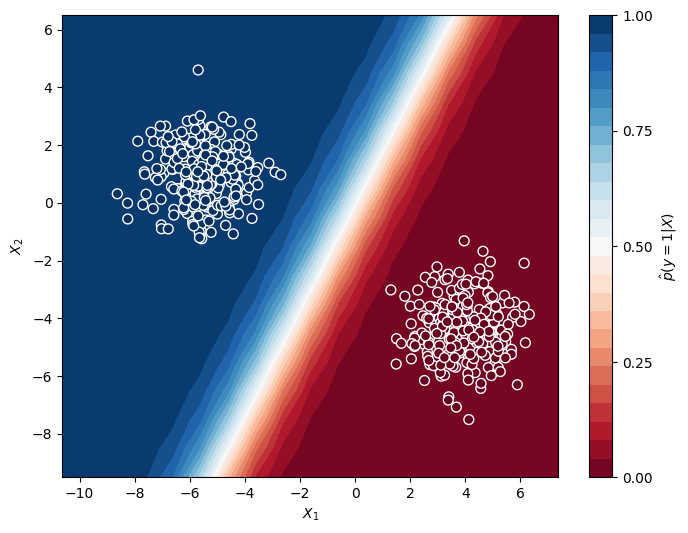

In [7]:
# Generate synthetic 2D data for classification. 
# Note that we used the same approach in our tutorial on clustering
from sklearn.datasets import make_blobs
tmp_X, tmp_y = make_blobs(n_samples=500, n_features=2, centers=2, cluster_std=1, random_state=123)

# Fit a logit model to the data (same code as above)
tmp_reg = LogisticRegression(random_state=123).fit(tmp_X, tmp_y)  # Train the mode

# Call our helper function for visualization
plot_logit_decision_surface(tmp_reg, tmp_X, tmp_y)

## Exercise 2: Probabilistic and discrete class prediction using the logistic regression classifier
The above demo has introduced the method `predict_proba()`, which any `sklearn`-based classification model supports. It gives you a an $n \times k$ array of probability predictions, where $n$ is the number of data points and $k$ is the number of classes. In our case, $k=2$. The first column of the array contains the probability of the negative class, and the second column contains the probability of the positive class. Classifiers also support a second method called `predict()`, which returns the predicted class labels. In our context these would be either 0 or 1, to denote the negative and positive class, respectively. Finally, an easy way to assess a trained classification models is to use the method `score()`. It returns the accuracy of the model, which is the proportion of correctly predicted labels. Let's explore these methods in more detail by solving the following tasks.

- Apply the method `score()` to the trained logistic regression classifier, which you can access through the variable `model`. Print the result as a percentage.
- Apply the method `predict()` to the training data and store the result in a variable called `y_pred`. Write code to compute the accuracy of the model manually. Compare the result with the output of the `score()` method.
- Apply the method `predict_proba()` to the training data and store the result in a variable called `y_pred_proba`. Write code to compute the accuracy of the model manually. Compare the result with the output of the `score()` method.
- Reusing the variable `y_pred_proba` computed in the previous exercise, write code to compute the mean squared error between your binary target variable `y` and the predicted probabilities `y_pred_proba`. This score is known as the *Brier Score* in the context of classification. 

**More advanced exercise (optional):**
- To set the performance of the logit model into context, compute the accuracy of a dummy classifier that always predicts the most frequent class. Compare the accuracy of the dummy classifier with the accuracy of the logistic regression model.


In [8]:
# Solutions to Exercise 2


# Measures of classifier performance
In the lecture, we discussed the confusion matrix and the ROC curve as tools to evaluate classification models. We will now demonstrate how to use these tools in Python. The `sklearn` library provides several functions to evaluate the performance of a classifier. In general, functionality for model evaluation is available in the module `sklearn.metrics`.

## Confusion matrix
The confusion matrix of a binary classifier is a 2x2 matrix that contains four values: true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN). The following image illustrates the confusion matrix and some common performance measures derived from it. 

<img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/confusion_matrix.PNG" width="854" height="480" alt="Confusion Matrix">

Let us produce a confusion matrix for our logistic regression model. To that end, we make use of the class `ConfusionMatrixDisplay` from the module `sklearn.metrics`. It is a convenient way to visualize the confusion matrix and offers two interfaces. You can either pass the true and predicted labels to the method `from_predictions()` or directly pass the trained classifier together with testing data to the method `from_estimator()`. We will demonstrate both approaches using the existing variables `model` (our trained logistic regression model) as well as `X` and `y`. Before moving on, note that `sklearn` also provides function to simply calculate the confusion matrix (i.e., without visualization). To achieve this, you can use the function `confusion_matrix()` from `sklearn.metrics`.

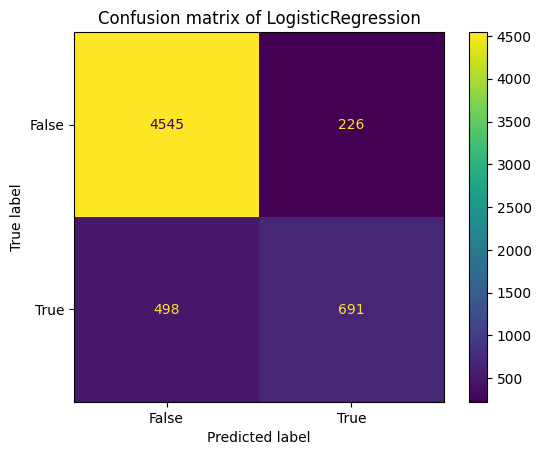

In [9]:
# Import the relevant class
from sklearn.metrics import ConfusionMatrixDisplay

# Compute predictions
yhat_class = model.predict(X)  # this produces discrete class predictions

# Visualize the confusion matrix in a plot
ConfusionMatrixDisplay.from_predictions(y_true=y, y_pred=yhat_class)  
plt.title(f"Confusion matrix of {type(model).__name__}")
plt.show()

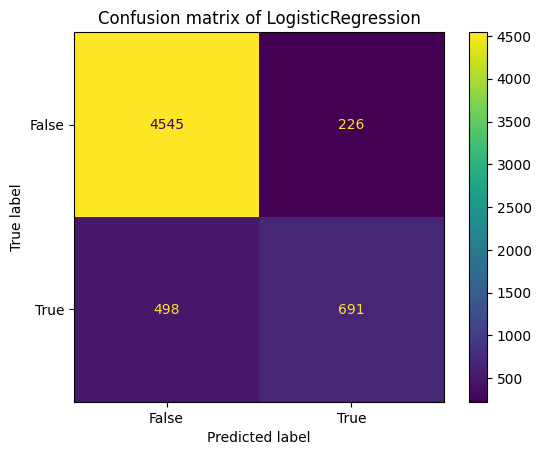

In [10]:
# Option 2 to plot the confusion matrix: note how the method from_estimator 
# bypasses the calculation of predictions. Instead of calling predict(), 
# we can directly give the trained model as argument
ConfusionMatrixDisplay.from_estimator(estimator=model, X=X, y=y)
plt.title(f"Confusion matrix of {type(model).__name__}")
plt.show()
  

### Classification report
While inspecting a confusion matrix is useful, it is also informative to consider the specific performance indicators derived from it. The `skelarn` library provides a classification report, which includes the classifier's precision, recall, and F1-score, defined as the harmonic mean of precision and recall: 

$$F_1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}$$ 

#### Exercise 3
Locate the function the function `classification_report` from the module `sklearn.metrics` and call it to create a classification report for the logistic regression model. Interpret the obtained results and try to phrase a conclusion about the model's performance.

In [11]:
# Solution to exercise 3


## ROC Curve
The main difference between ROC analysis and the confusion matrix, as well as accuracy indicators derived from the confusion matrix is that ROC analysis considers all possible thresholds for classifying observations. Specifically, the ROC curve is a graphical representation of the trade-off between the true positive rate (TPR) and the false positive rate (FPR) for different classification thresholds. The area under the ROC curve (AUC) is a single number summary of a classifier's ROC curve and a widely used indicator when comparing alternative classifiers.  


<img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/ROC-curve.png" width="854" height="480" alt="Confusion Matrix">


### Exercise 4
Your task is to examine the performance of the logistic regression (i.e., `model`) using ROC analysis. Specifically:
- Import the function `roc_auc_score` and the class `RocCurveDisplay` from `sklearn.metrics` 
- Compute probabilistic predictions and store the results in a variable `yhat_proba`
- Compute the AUC using the function `roc_auc_score` and print the result.
- Use the the class `RocCurveDisplay` to plot an ROC curve for the logistic regression model. Note that the use of the class is identical to the `ConfusionMatrixDisplay` class, which we used earlier.


In [12]:
# Solution to exercise 4


# Congratulations. You made it to the end of yet another challenging tutorial notebook.